In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore')

In [83]:
from scipy.optimize import curve_fit

from sklearn.linear_model import LinearRegression, BayesianRidge, TweedieRegressor
from sklearn.svm import SVR
from sklearn.tree import ExtraTreeRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from pykrige.rk import RegressionKriging
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging

import gstools as gs

## Функция

In [84]:
"""
Удаление выбросов с использованием межквартильного размаха (IQR)
"""
def get_filter_df(df, col):
    # Определяем Q1 и Q3 квартили
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    
    # Вычисляем IQR
    IQR = Q3 - Q1
    
    # Определяем границы для определения выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Фильтруем выбросы
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [85]:
def gamma_igi(h_list):
    out = []
    for h in h_list:
        if h <= 5:
            out.append(1.81)
        elif h <= 6:
            out.append(1.93)
        else: 
            out.append(1.94)
    return out

## Исходные данные

In [86]:
df_house_3 = pd.read_excel("data/house_3_local.xlsx")
max_borehole = df_house_3["тсз"].max()

In [87]:
"""
Случайная разбивка данных
"""
borehole = 147
z_borehole = 76.385 # абсолютная отметка устья скважины
clay_border = [73.5, 65]
#df_now = group_E.query('group == 65')
df = pd.read_excel(f"data/тсз{borehole}.xlsx")
df["z_sample"] = z_borehole - df["h"]
df = df.query('z_sample < @clay_border[0] & z_sample > @clay_border[1]') 
df["x"] = 0
df = df.loc[:, ["x", "h", "E"]]
df_now = get_filter_df(df, "E")

x_train = df_now.loc[:, ["x", "h"]].to_numpy()
target_train = df_now.loc[:, ["E"]].to_numpy()[:, 0]

r2_dict = {}

In [88]:
"""
Случайная разбивка данных  + добавление постоянных значений в тестовую выборку
    -только суглинок (залегает от 73,5 до 67-64,4)
    -пласт подряд идущих данных отнесен к тестовой выборке
    -отсортированные данные
"""
borehole = 147
z_borehole = 76.385 # абсолютная отметка устья скважины
clay_border = [73.5, 65]
#df_now = group_E.query('group == 65')
df = pd.read_excel(f"data/тсз{borehole}.xlsx")

df["z_sample"] = z_borehole - df["h"]
df = df.query('z_sample < @clay_border[0] & z_sample > @clay_border[1]') 
df["x"] = 0
df = df.loc[:, ["x", "h", "E"]]
df_now = get_filter_df(df, "E")

data_train, data_test = train_test_split(
    #df_now.iloc[:91].to_numpy(),
    pd.concat([df_now.iloc[:91], df_now.iloc[128:]]).to_numpy(), 
    test_size=0.1, 
    random_state=123
)

data_train = data_train[np.argsort(data_train[:, 1])]
data_test = np.concatenate([data_test,
                            #df_now.iloc[92:].to_numpy()
                            df_now.iloc[92:128].to_numpy()
                           ]
                          )
data_test = data_test[np.argsort(data_test[:, 1])]
p_train, x_train, target_train = data_train[:, :2], data_train[:, :2], data_train[:, 2]
p_test, x_test, target_test = data_test[:, :2], data_test[:, :2], data_test[:, 2]

r2_dict = {}

In [89]:
"""
Случайная разбивка данных  + добавление постоянных значений в тестовую выборку
    -только суглинок (залегает от 73,5 до 67-64,4)
    -пласт подряд идущих данных отнесен к тестовой выборке
    -отсортированные данные
"""
borehole = 147
z_borehole = 76.385 # абсолютная отметка устья скважины
clay_border = [73.5, 65]
#df_now = group_E.query('group == 65')
df = pd.read_excel(f"data/тсз{borehole}.xlsx")

df["z_sample"] = z_borehole - df["h"]
df = df.query('z_sample < @clay_border[0] & z_sample > @clay_border[1]') 
df["x"] = 0
df = df.loc[:, ["x", "h", "E"]]
df_all = get_filter_df(df, "E")

data_all = df_all.copy().to_numpy()

data_train, data_test = train_test_split(
    df_all.iloc[:91].to_numpy(),
    #pd.concat([df_now.iloc[:91], df_now.iloc[128:]]).to_numpy(), 
    test_size=0.1, 
    random_state=123
)

data_train = data_train[np.argsort(data_train[:, 1])]
data_test = np.concatenate([data_test,
                            df_now.iloc[92:].to_numpy()
                            #df_now.iloc[92:128].to_numpy()
                           ]
                          )
data_test = data_test[np.argsort(data_test[:, 1])]
p_train, x_train, target_train = data_train[:, :2], data_train[:, :2], data_train[:, 2]
p_test, x_test, target_test = data_test[:, :2], data_test[:, :2], data_test[:, 2]

r2_dict = {}

"""
Запись всех значений true_values
"""
step_group = 1
df_now = pd.DataFrame({"E": data_all[:,2],
                         "h":data_all[:,1],
                        "gamma":gamma_igi(data_all[:,1])
                        }
                       )
df_now["group"] = df_now["h"]//step_group
df_now = df_now.groupby(by="group").mean().drop(columns=["h"])
df_now["soil"] = range(1, df_now.shape[0]+1)
df_now["z"] = step_group
df_now.to_excel("soil_plaxis_true_values.xlsx")

## Построение

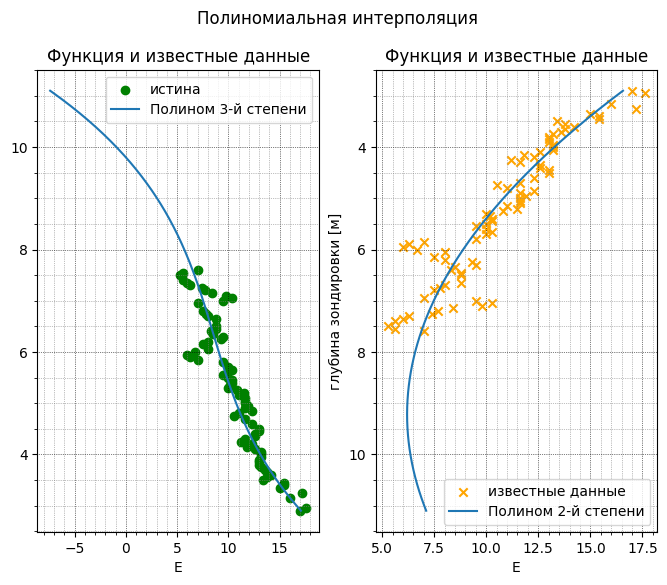

In [90]:
"""
Полином
"""
xi = x_train[:, 1]
yi = target_train

poly1 = np.poly1d(np.polyfit(xi, yi, 3))
poly2 = np.poly1d(np.polyfit(xi, yi, 2))

x_new = np.linspace(min(xi), 
                    max(xi)+3.5, 
                    300
                   )
y1_new = poly1(xi)
y2_new = poly2(xi)
#подграфики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

#график на первом поле
ax1.scatter(target_train, x_train[:, 1], color='green', label='истина')
ax1.plot(poly1(x_new), x_new, label=f'Полином 3-й степени')
ax1.set_title('Функция и известные данные')
ax1.set_xlabel('E')
ax1.grid(which='major', linestyle=':', linewidth='0.5', color='black')
ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
ax1.minorticks_on()
ax1.legend()

#график на втором поле
ax2.scatter(target_train, x_train[:, 1], marker="x", color='orange', label='известные данные')
ax2.plot(poly2(x_new), x_new, label=f'Полином 2-й степени')
ax2.set_title('Функция и известные данные')
ax2.set_xlabel('E')
ax2.grid(which='major', linestyle=':', linewidth='0.5', color='black')
ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
ax2.minorticks_on()
ax2.legend()

# Установите общий заголовок
fig.suptitle('Полиномиальная интерполяция')
plt.ylabel('глубина зондировки [м]')
plt.gca().invert_yaxis()
plt.show()

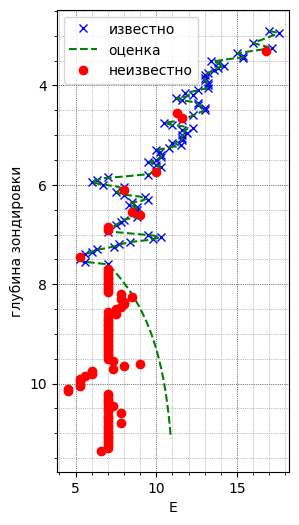

In [91]:
"""
Универсальный кригинг
"""
model = 'exponential'

x = x_train[:, 0]
y = x_train[:, 1]
E = target_train

UK = UniversalKriging(x, 
                      y, 
                      E, 
                      variogram_model=model
                        )


x_new = np.array([0]*200)
y_new = np.linspace(np.min(y), np.max(y)+3.5, 200)
z_new, variance = UK.execute('points', x_new, y_new)

plt.figure(figsize=(3, 6))
plt.plot(target_train, x_train[:, 1], 'bx', label="известно")
plt.plot(z_new, y_new, 'g--', label="оценка")
plt.plot(target_test, p_test[:, 1], 'ro', label="неизвестно")
plt.xlabel('E')
plt.ylabel('глубина зондировки')
plt.gca().invert_yaxis()
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.legend()
plt.show()

regression model: TweedieRegressor TweedieRegressor()
-1.069221880524768


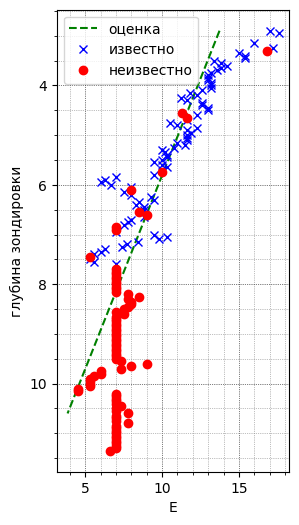

In [92]:
"""
TweedieRegressor()
"""
tr_model = TweedieRegressor()

    
print("=" * 40)
print("regression model:", tr_model.__class__.__name__, tr_model)

tr_model.fit(p_train, target_train)


predict_test = tr_model.predict(p_test)
print(r2_score(target_test, predict_test))

x_ml = np.array([0]*200)
y_ml = np.linspace(np.min(x_train[:, 1]), np.max(x_train[:, 1])+3, 200)
data_ml = np.array([x_ml, y_ml]).T
z_ml = tr_model.predict(data_ml)
    
plt.figure(figsize=(3, 6))
plt.plot(z_ml, y_ml, 'g--', label="оценка")
plt.plot(target_train, p_train[:, 1], 'bx', label="известно")
plt.plot(target_test, p_test[:, 1], 'ro', label="неизвестно")
plt.xlabel('E')
plt.ylabel('глубина зондировки')
plt.gca().invert_yaxis()
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.legend()
plt.show()

Finished learning regression model
Finished kriging residuals
0.45394354976813955 0.8559202237548288 1.1137846640282698


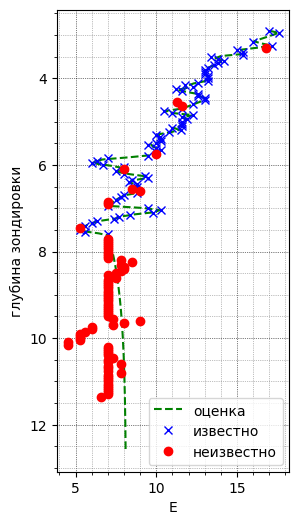

In [93]:
"""
Регрес кригинг
"""
m = SVR(C=0.1, gamma="auto", kernel="sigmoid")


    
try:
        m_rk = RegressionKriging(regression_model=m, n_closest_points=10, variogram_model='exponential')
        m_rk.fit(p_train, x_train, target_train)

        x_new = np.array([0]*200)
        y_new = np.linspace(np.min(y), np.max(y)+5, 200)
        data = np.array([x_new, y_new]).T
        z_new = m_rk.predict(data, data)

        predict_test = m_rk.predict(p_test, x_test)

        r2_now = r2_score(target_test, predict_test)
        mae_now = mean_absolute_error(target_test, predict_test)
        rmse_now = mean_squared_error(target_test, predict_test)**0.5
        print(r2_now, mae_now, rmse_now)

        z_new = m_rk.predict(data, data)
        plt.figure(figsize=(3, 6))
        plt.plot(z_new, y_new, 'g--', label="оценка")
        plt.plot(target_train, p_train[:, 1], 'bx', label="известно")
        plt.plot(target_test, x_test[:, 1], 'ro', label="неизвестно")
        plt.xlabel('E')
        plt.ylabel('глубина зондировки')
        plt.gca().invert_yaxis()
        plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
        plt.minorticks_on()
        plt.legend()
        plt.show()

except Exception as ex:
        print(ex)

## Сохранение данных
    ИГЭ 3а  
        с 2-5м  
        гамма = 1.81  
    ИГЭ 3б  
        с  5-6м  
        гамма = 1.93  
    ИГЭ 3в  
        с 6м  
        гамма = 1.94  

In [94]:
def gamma_igi(h_list):
    out = []
    for h in h_list:
        if h <= 5:
            out.append(1.81)
        elif h <= 6:
            out.append(1.93)
        else: 
            out.append(1.94)
    return out

In [95]:
step_group = 1

In [96]:
df_now = pd.DataFrame({"E":poly1(np.linspace(np.min(x_train[:, 1]), np.max(x_train[:, 1])+3, 100)),
                         "h":np.linspace(np.min(x_train[:, 1]), np.max(x_train[:, 1])+3, 100),
                       "gamma":gamma_igi(np.linspace(np.min(x_train[:, 1]), np.max(x_train[:, 1])+3, 100))
                        }
                       )
df_now["group"] = df_now["h"]//step_group
df_now = df_now.groupby(by="group").mean().drop(columns=["h"])
df_now["soil"] = range(1, df_now.shape[0]+1)
df_now["z"] = step_group
df_now.to_excel("soil_plaxis_poly1_1m.xlsx")

In [97]:
df_now = pd.DataFrame({"E": UK.execute('points', 
                                       np.linspace(np.min(x_train[:, 0]), np.max(x_train[:, 0])+3, 100), 
                                       np.linspace(np.min(x_train[:, 1]), np.max(x_train[:, 1])+3, 100)
                                      )[0],
                         "h":np.linspace(np.min(x_train[:, 1]), np.max(x_train[:, 1])+3, 100),
                        "gamma":gamma_igi(np.linspace(np.min(x_train[:, 1]), np.max(x_train[:, 1])+3, 100))
                        }
                       )
df_now["group"] = df_now["h"]//step_group
df_now = df_now.groupby(by="group").mean().drop(columns=["h"])
df_now["soil"] = range(1, df_now.shape[0]+1)
df_now["z"] = step_group
df_now.to_excel("soil_plaxis_UK_1m.xlsx")

"""
tr_model
"""
df_now = pd.DataFrame({"E": tr_model.predict(data_ml),
                         "h":y_ml,
                        "gamma":gamma_igi(y_ml)
                        }
                       )
df_now["group"] = df_now["h"]//step_group
df_now = df_now.groupby(by="group").mean().drop(columns=["h"])
df_now["soil"] = range(1, df_now.shape[0]+1)
df_now["z"] = step_group
df_now.to_excel("soil_plaxis_tr.xlsx")

In [98]:
"""
poly2 Полином 2ой степени
"""
df_now = pd.DataFrame({"E":poly2(np.linspace(np.min(x_train[:, 1]), np.max(x_train[:, 1])+3, 100)),
                         "h":np.linspace(np.min(x_train[:, 1]), np.max(x_train[:, 1])+3, 100),
                        "gamma":gamma_igi(np.linspace(np.min(x_train[:, 1]), np.max(x_train[:, 1])+3, 100))
                        }
                       )
df_now["group"] = df_now["h"]//step_group
df_now = df_now.groupby(by="group").mean().drop(columns=["h"])
df_now["soil"] = range(1, df_now.shape[0]+1)
df_now["z"] = step_group
df_now.to_excel("soil_plaxis_poly2_1m.xlsx")

In [99]:
"""
Kr+SVR
"""
df_now = pd.DataFrame({"E": m_rk.predict(data_ml, 
                                       data_ml
                                      ),
                         "h":y_ml,
                        "gamma":gamma_igi(y_ml)
                        }
                       )
df_now["group"] = df_now["h"]//step_group
df_now = df_now.groupby(by="group").mean().drop(columns=["h"])
df_now["soil"] = range(1, df_now.shape[0]+1)
df_now["z"] = step_group
df_now.to_excel("soil_plaxis_K+SVR_1m.xlsx")